<a href="https://colab.research.google.com/github/F-Yousefi/House_Price_Prediction/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction Using Linear Regression
### Linear Regression impelementation from scratch.
 *Normal Equation - Gradient Descent*
 </br></br></br>

###Preface
The dataset that this project is based on can be found throug [Tehran (Divar.ir) House Price Prediction](https://www.kaggle.com/code/soheiltehranipour/tehran-divar-ir-house-price-prediction) thanks to [Dr. Soheil Tehranipour](https://www.kaggle.com/soheiltehranipour) who has done a very excellent job in the area of AI and ML. In this project, I will discuss how to use pandas and numpy libraries in order to do some preprocessing on this amazing dataset, and then we continue to learn how Linear Regression model works. As far as I know, there are two version of this model; one uses Gradient descent to find the correct coefficients and intercept and the other one uses Normal equation. The good news is that the both version of the Linear Regression will be discussed in this notebook.
 </br></br></br>


###Preprocessing
To take advantage of this wonderful dataset, we first need to intuitively understand the properties of this dataset such as datatype of each column. Additionally, we need to figure out if there are any outliers or not, because this made our model more accurate in the future. Fortunately, all of this tasks can be performed by pandas and numpy libraries.


In [ ]:
!git clone https://github.com/F-Yousefi/House_Price_Prediction.git
%cd House_Price_Prediction

In [ ]:
#We're going to use pandas and numpy, so let's import them now.
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Let's first read the dataset which is saved in the form of .csv file.
dataset = pd.read_csv('./dataset/divar_tehran_dataset/DivarHousePrice.csv')
dataset.head() # this command will preview five top rows of the dataset.

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [ ]:
#this command print a concise summary of the information about the dataset including
#the index dtype and columns, non-null values and memory usage.

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


In [ ]:
#this command analyse the data stored in each column of the dataset including
#maximum value, minimum value, mean, count, standard deviation, and normal distribution.

dataset.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [ ]:
#We should be very careful about null and nan values in any datasets.
#We can make sure there is no nan or null values in the dataset using this command.
dataset.isnull().sum()

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64

In [ ]:
#As you can also see there are 23 samples with nan or null values. We should remove them from our dataset.
#In pandas we do this using the command dorpna which is actually drop+nan-> dropna().
dataset = dataset.dropna()

In [ ]:
#Sometimes we need to know more about a feature of all samples.
#For example, we want to know what percentage of the houses have come with an elevator.
dataset['Elevator'].value_counts(normalize=True)*100

True     78.732639
False    21.267361
Name: Elevator, dtype: float64

In [ ]:
# Using the method groupby, you can the mean price corresponding to each city/address.
# It would be great, because in fact, various cities and addresses will have various price.
# For example, we know house price in "Lavasan" is much higher than "Malard" now.
dataset.groupby( ['Address'] )['Price'].mean().sort_values().reset_index()

,Address,Price
0,Malard,2.500000e+08
1,Robat Karim,3.275000e+08
2,Pishva,3.400000e+08
3,Firoozkooh,4.700000e+08
4,Hassan Abad,5.100000e+08
...,...,...
187,Elahieh,2.678635e+10
188,Vanak,3.270000e+10
189,Mahmoudieh,3.346667e+10
190,Lavasan,4.800000e+10


In [ ]:
#Let's now convert all of the columns of the dataset into integer, so that we can
#use the dataset in the future model or further calculation.
boolean_features = ['Parking','Warehouse','Elevator']
dataset[boolean_features] = dataset[boolean_features].astype('int64')
# dataset["Area"] = dataset["Area"].astype('int64')

In [ ]:
#As you can see the error above and the following dataset's info, the column "Area"
#contains a wrong value of"' 3,310,000,000 '" which is a price in type of string.
#To tackle this problem, we should find all the wrong values in this column and drop them.
#we first define a method to recognize values that can not be converted to integer.
def is_int(element: any) -> bool:
    #If you expect None to be passed:
    if element is None:
        return False
    try:
        int(element)
        return True
    except ValueError:
        return False
#Then we apply this method on every row of this column. Next, we update the dataset
dataset = dataset[ dataset["Area"].apply(is_int) ]

In [ ]:
# Now there won't be any problem here.
dataset["Area"] = dataset["Area"].astype('int64')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3450 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3450 non-null   int64  
 1   Room        3450 non-null   int64  
 2   Parking     3450 non-null   int64  
 3   Warehouse   3450 non-null   int64  
 4   Elevator    3450 non-null   int64  
 5   Address     3450 non-null   object 
 6   Price       3450 non-null   float64
 7   Price(USD)  3450 non-null   float64
dtypes: float64(2), int64(5), object(1)
memory usage: 242.6+ KB


In [ ]:
#You can now drop the columns that you don't need.
dataset = dataset.drop(columns = ['Price(USD)'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3450 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3450 non-null   int64  
 1   Room       3450 non-null   int64  
 2   Parking    3450 non-null   int64  
 3   Warehouse  3450 non-null   int64  
 4   Elevator   3450 non-null   int64  
 5   Address    3450 non-null   object 
 6   Price      3450 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 215.6+ KB


### Visualization
It is to build up an intuitive understanding for youself and everyone else using this dataset. This way, you can have an imagination of how ML algorithm would behave. In addition, you can find the outlier more easier. Removing all the outliers will help your model converge better and faster.

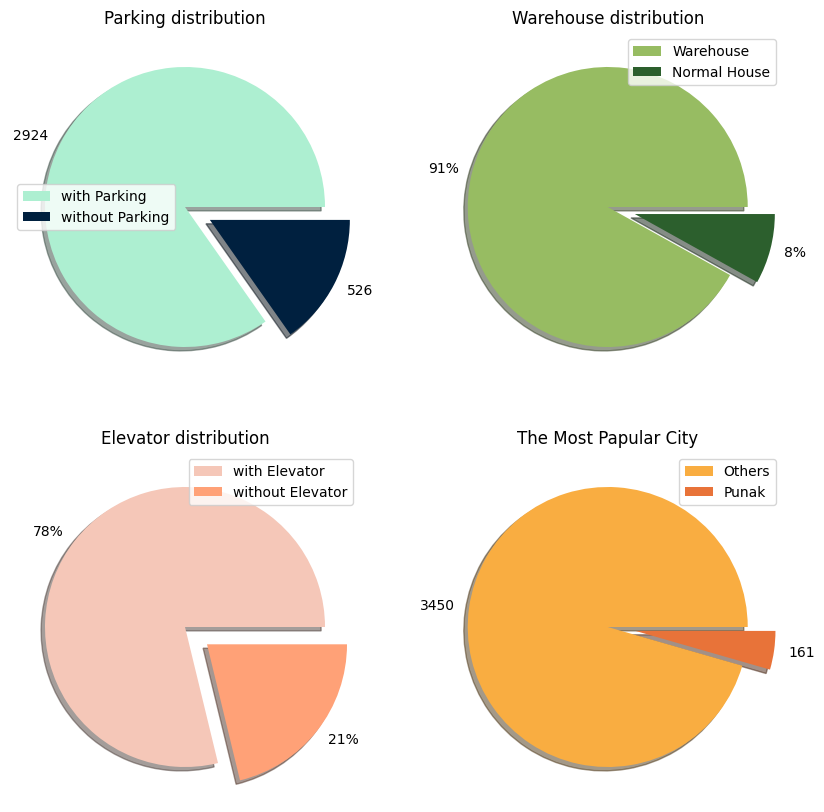

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# We define a grid to plot 4 diagrams. We have a grid of 2 columns and 2 rows
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(10,10))

# We define a list of eight colors that mutually are used in the diagrams. One for the slice and the other for the pie.
colors = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D'], ['#F5C7B8FF', '#FFA177FF'],["#f9ad41","#e87339"]]
explode = [0, 0.2]
columns = ['Parking', 'Warehouse', 'Elevator']

#First Pie Chart Definition. It illustrates how many houses have come with parking.
data = dataset[columns[0]].value_counts()
ax[0,0].pie(data, labels=data, explode=explode, colors=colors[0], shadow=True)
ax[0,0].legend(labels=("with {0}".format(columns[0]),"without {0}".format(columns[0])), fontsize='medium')
ax[0,0].set_title('{0} distribution'.format(columns[0]))

#Second Pie Chart Definition. It illustrates what precentage of the houses are warehouse.
data = (dataset[columns[1]].value_counts(normalize=True)* 100).astype(int)
ax[0,1].pie(data, labels=("{0}%".format(data[1]),"{0}%".format(data[0])), explode=explode, colors=colors[1], shadow=True)
ax[0,1].legend(labels=(columns[1],"Normal House"), fontsize='medium')
ax[0,1].set_title('{0} distribution'.format(columns[1]))

#Third Pie Chart Definition. It represents how many houses have come with elevator.
data = (dataset[columns[2]].value_counts(normalize=True)* 100).astype(int)
ax[1,0].pie(data, labels=("{0}%".format(data[1]),"{0}%".format(data[0])), explode=explode, colors=colors[2], shadow=True)
ax[1,0].legend(labels=("with {0}".format(columns[2]),"without {0}".format(columns[2])), fontsize='medium')
ax[1,0].set_title('{0} distribution'.format(columns[2]))


#Forth Pie Chart Definition. It shows Punak is the most popular city, full of available houses.
address_grouped = dataset.groupby( ['Address'] ).size().reset_index()
most_papular_city = address_grouped[address_grouped[0] == np.max(address_grouped[0])].to_numpy()[0]

ax[1,1].pie((len(dataset),most_papular_city[1]), labels=((len(dataset),most_papular_city[1])),\
          explode=explode, colors=colors[3], shadow=True)
ax[1,1].legend(labels=("Others",most_papular_city[0]), fontsize='medium')
_= ax[1,1].set_title('The Most Papular City')

##Outliers
An Outlier is a data-item/object that deviates significantly from the rest of the (so-called normal)objects. They can be caused by measurement or execution errors. The analysis for outlier detection is referred to as outlier mining. There are many ways to detect the outliers, and the removal process is the data frame same as removing a data item from the panda’s data frame.

Here pandas data frame is used for a more realistic approach as in real-world projects need to detect the outliers arouse during the data analysis step, the same approach can be used on lists and series-type objects. [Thacks to Geeksforgeeks](https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/)

<Axes: >

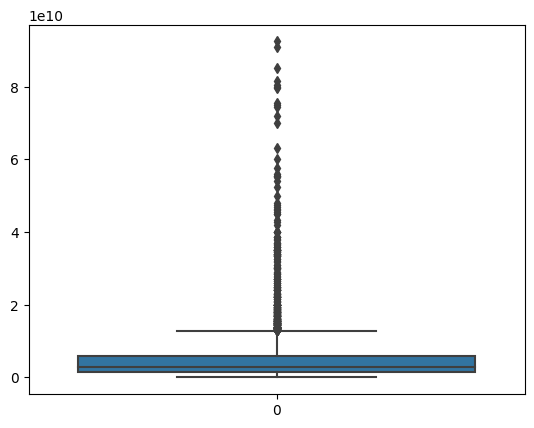

In [ ]:
"""It captures the summary of the data effectively and efficiently with only a
simple box and whiskers. Boxplot summarizes sample data using 25th, 50th, and
75th percentiles.One can just get insights(quartiles, median, and outliers) into
the dataset by just looking at its boxplot.Thacks to Geeksforgeeks"""
# Box Plot
import seaborn as sns
sns.boxplot(dataset["Price"])

(0.0, 800.0)

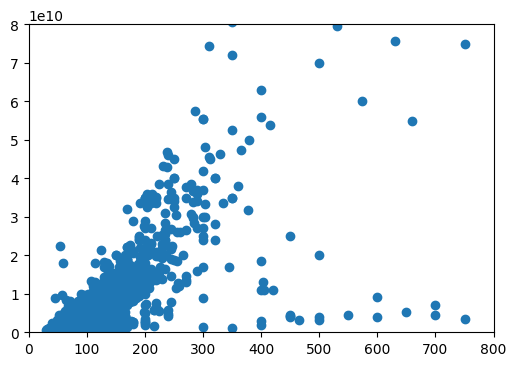

In [ ]:
"""Visualizing Outliers Using ScatterPlot.
It is used when you have paired numerical data and when your dependent variable
has multiple values for each reading independent variable, or when trying to
determine the relationship between the two variables. In the process of utilizing
the scatter plot, one can also use it for outlier detection.Thacks to Geeksforgeeks"""

fig, ax = plt.subplots(figsize = (6,4))
ax.scatter(dataset['Area'],dataset['Price'])
ax.set_ylim((0,8e+10))
ax.set_xlim((0,800))

In [ ]:
#In this section we want to find outliers and remove all of them. We apply this
#approach only on two columns "Price" and "Area" because these two columns can
#have various values. As you saw before, the other values of the other columns
#are somehow limited.
dataset.drop(columns = ["Address"],inplace=True)
dataset.reset_index(drop = True,inplace=True)
print("Previous dataset shape :",dataset.shape)

# IQR
# Calculate the upper and lower limits
Q1 = dataset[["Area","Price"]].quantile(0.25)
Q3 = dataset[["Area","Price"]].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset[["Area","Price"]]>=upper)[0]
lower_array = np.where(dataset[["Area","Price"]]<=lower)[0]


# Removing the outliers
outliers = dataset.iloc[upper_array]
old_dataset = dataset.copy()
dataset.drop(index=upper_array, inplace=True)
dataset = dataset.copy().reset_index(drop = True)

# Print the new shape of the DataFrame
print("New dataset shape :",dataset.shape)


Previous dataset shape : (3450, 6)
New dataset shape : (3089, 6)


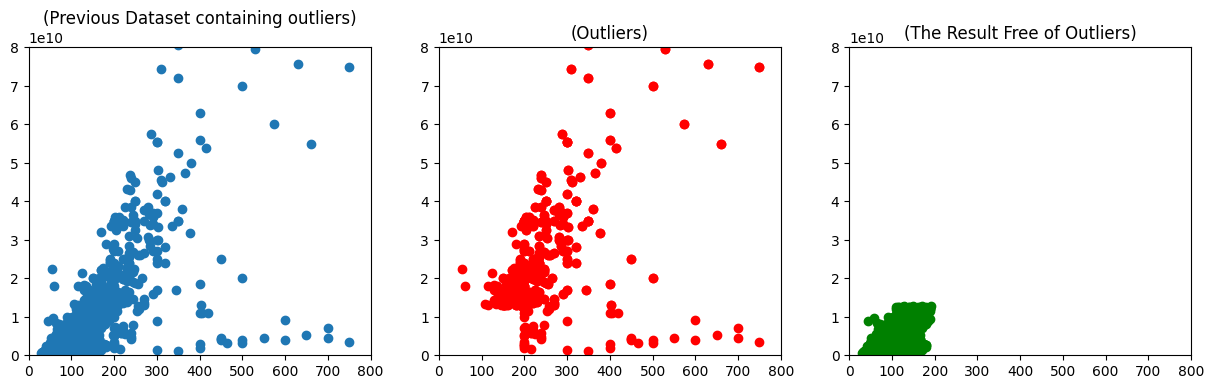

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize = (15,4))
ax[0].scatter(old_dataset['Area'],old_dataset['Price'])
ax[1].scatter(outliers['Area'],outliers['Price'],color = "red")
ax[2].scatter(dataset['Area'],dataset['Price'], color = "green")


# x-axis label
ax[0].set_title("(Previous Dataset containing outliers)")
ax[1].set_title("(Outliers)")
ax[2].set_title("(The Result Free of Outliers)")

ax[0].set_ylim((0,8e+10))
ax[1].set_ylim((0,8e+10))
ax[2].set_ylim((0,8e+10))

ax[0].set_xlim((0,800))
ax[1].set_xlim((0,800))
ax[2].set_xlim((0,800))
# y-axis label
plt.show()

#Skewness:
Skewness tells us the direction of outliers. In a positive skew, the tail of a distribution curve is longer on the right side. This means the outliers of the distribution curve are further out towards the right and closer to the mean on the left. As we remove the outliers, we will see the size of skewness will reduce.

<center>
<br>

### Skewness in different situations
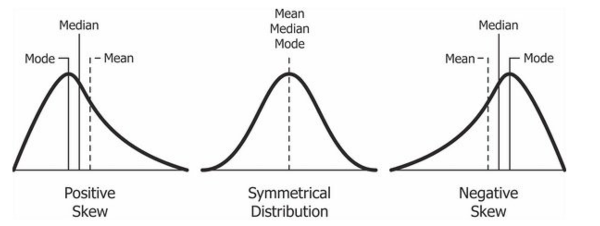
</center>

In [ ]:
# As you can see, Skewness of the features "Price" and "Area" have been reduced.
print(f"Skewness of features of the dataset (containing outliers):\n{old_dataset.skew()}")
print("\n")
print(f"Skewness of features of the dataset (free of outliers):\n{dataset.skew()}")

Skewness of features of the dataset (containing outliers):
Area         4.488354
Room         0.623884
Parking     -1.934446
Warehouse   -2.979139
Elevator    -1.406481
Price        4.766985
dtype: float64


Skewness of features of the dataset (free of outliers):
Area         0.672756
Room         0.163801
Parking     -1.798618
Warehouse   -2.901748
Elevator    -1.393130
Price        1.285909
dtype: float64


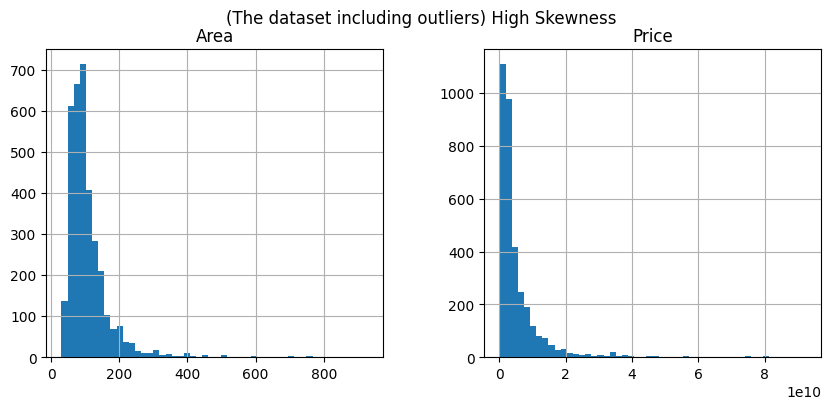

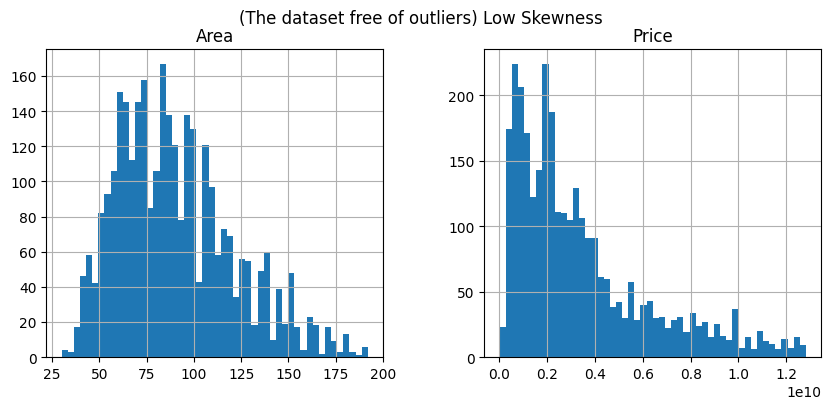

In [ ]:
from scipy.stats import norm
import statistics

old_dataset.hist(column=["Area","Price"],figsize=(10,4),bins=50)
plt.suptitle("(The dataset including outliers) High Skewness")
dataset.hist(column=["Area","Price"],figsize=(10,4),bins=50)
plt.suptitle("(The dataset free of outliers) Low Skewness")
plt.show()


##Linear Regression:
Every algorithm that predicts a number between infinit numbers is called Regression model such as Linear Regression, Decision Tree, and Random Forest . It is very important to know more about the applications of regression algorithms, so that you can understand what kind of problems can be addressed using, for exampele, Linear Regression. Linear Regression is amonge the simplest machine learning algorithms. Let's learn this algorithm as a foundation.
we will need some notations here:
x :

> $x$ → input variable or feature <br>
> $y$ → output variable or target variable <br>
> $m$ → the number of samples <br>
> $(x^{(i)},y^{(i)})$  → $i^{th}$ training sample
> $w,b$ \→ parameters or coefficients

$$X_{input} ⇒ f_{model}(X) ⇒ \hat{y}_{predict}$$<br>
$$f_{w,b}(X) = w⃗ . x⃗ + b$$<br>

+ For the cost fuction, we want to introduce you to "Squared Error Cost Function" which is most commonly used by people in machine learning community as the cost fuction for linear regression model.

<br>

$$Cost\space Function(Linear\space Regression)\space J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2$$



In [ ]:
#There is a module called "linear_regression" inside of it you can find the
#python file including LinearRegression class. You need to import the package.
from linear_regression.model import LinearRegressionGD
from sklearn.preprocessing import normalize

#['Area', 'Room', 'Parking', 'Warehouse', 'Elevator'] x.shape:[3000 x 5]
x = dataset[dataset.columns[:-1]].to_numpy()
#[Reshape Price vector to a matrix] y.shape: [3000] reshaped-> [3000 x 1]
y = dataset[dataset.columns[-1]].to_numpy().reshape((-1, 1))

#Normalize the dataset to help model converge faster.
x_norm = normalize(x,axis=0,norm="max")
y_norm = normalize(y,axis=0,norm="max")
#creating an instance.
model = LinearRegressionGD()# Using the Gradient Descent method
model = model.fit(x_norm,y_norm,alpha=0.54,acceptable_cost=1e-5)


LINEAR REGRESSION: training process has been started ...

ITERATION: #100 ,
 COST: 0.1189627,
 COEFFICIENT VALUE: [[ 0.8614905 -0.0376876  0.1798555  0.1107676  0.1335254]],                        
 INTERCEPT VALUE: [-0.0363718] 
ITERATION: #200 ,
 COST: 0.0150438,
 COEFFICIENT VALUE: [[ 0.8903405 -0.0579934  0.0780531  0.043306   0.0435008]],                        
 INTERCEPT VALUE: [-0.2002255] 
ITERATION: #300 ,
 COST: 0.0124815,
 COEFFICIENT VALUE: [[ 0.912718  -0.0701752  0.0606532  0.0339711  0.0288379]],                        
 INTERCEPT VALUE: [-0.2303011] 
ITERATION: #400 ,
 COST: 0.0124127,
 COEFFICIENT VALUE: [[ 0.9264557 -0.0819965  0.0576342  0.032843   0.026291 ]],                        
 INTERCEPT VALUE: [-0.2358517] 
ITERATION: #500 ,
 COST: 0.0124075,
 COEFFICIENT VALUE: [[ 0.9357532 -0.092358   0.0570775  0.0326792  0.0257598]],                        
 INTERCEPT VALUE: [-0.2366121] 
ITERATION: #600 ,
 COST: 0.0124052,
 COEFFICIENT VALUE: [[ 0.9426195 -0.1008801  

In [ ]:
#The best possible score is 1.0 and it can be negative (because the
#model can be arbitrarily worse). A constant model that always predicts
#the expected value of y, disregarding the input features, would get
#a R^2 score of 0.0.
model.score(x_norm,y_norm)

0.49730699888671936

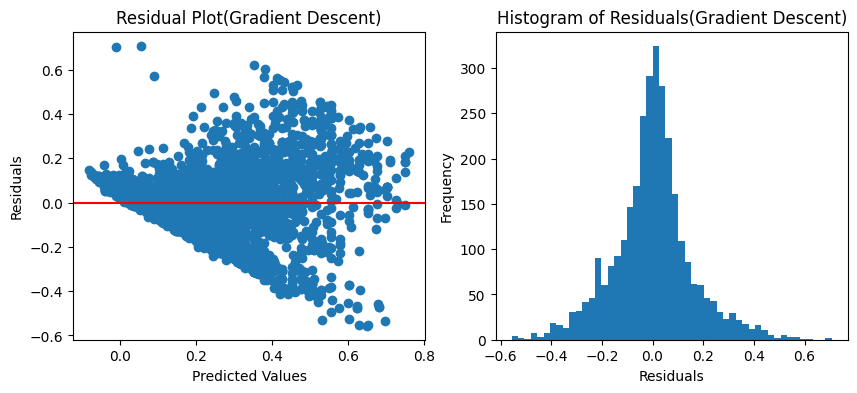

In [ ]:
#A residual is a measure of how far away a point is vertically from the
#regression line. Simply, it is the error between a predicted value and
#the observed actual value.

y_true , y_pred = y_norm, model.predict(x_norm)
residuals = y_true - y_pred

fig, ax = plt.subplots(ncols=2,figsize = (10,4))

ax[0].scatter(y_pred, residuals)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].axhline(y=0, color='r', linestyle='-')
ax[0].set_title('Residual Plot(Gradient Descent)')

ax[1].hist(residuals, bins=50)
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Residuals(Gradient Descent)')
plt.show()

In [ ]:
#There is a module called "linear_regression" inside of it you can find the
#python file including LinearRegression class. You need to import the package.
from linear_regression.model import LinearRegressionNE

#creating an instance.
model = LinearRegressionNE() # Using the Normal Equation method
model = model.fit(x_norm,y_norm)

In [ ]:
#The best possible score is 1.0 and it can be negative (because the
#model can be arbitrarily worse). A constant model that always predicts
#the expected value of y, disregarding the input features, would get
#a R^2 score of 0.0.
model.score(x_norm,y_norm)

0.4974198672000122

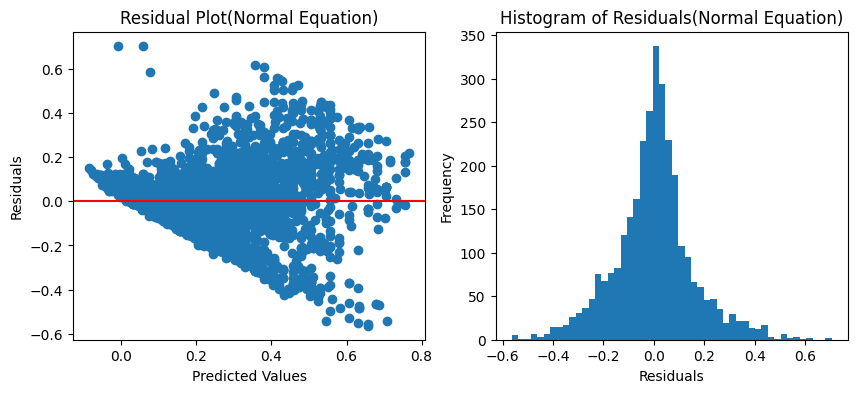

In [ ]:
y_true , y_pred = y_norm, model.predict(x_norm)
residuals = y_true - y_pred

fig, ax = plt.subplots(ncols=2,figsize = (10,4))

ax[0].scatter(y_pred, residuals)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].axhline(y=0, color='r', linestyle='-')
ax[0].set_title('Residual Plot(Normal Equation)')

ax[1].hist(residuals, bins=50)
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Residuals(Normal Equation)')
plt.show()

Over this notebook, some major topics of machine learning and AI were represented, such as preprocessing, visualising, and training and testing. Make sure to apply metioned mathods on your dataset too, it will help you understand the dataset better.